In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer, KNNImputer
from tqdm import tqdm_notebook
from venn import venn
from sklearn.decomposition import PCA
import pickle
from sklearn.preprocessing import MinMaxScaler

In [32]:
pd.options.display.max_columns = 50
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (10.0, 7.0)


In [3]:
seed = 42

In [5]:
drug_df = pd.read_csv("../../data/drug/drug_final_processed.csv.gz", low_memory=False)

In [6]:
drug_df.head()

,num_replicates,RMSE,drug_id,sample_treatment,putative_target,model_treatment,model_name,msi_status,CHEMBL,cell_line_name,model_synonyms,cancer_type_detail,drug_name,putative_gene_target,use_in_publications,model_type,drug_synonyms,RRID,dataset,ln_IC50,model_id,drug_owner,BROAD_ID,master_cell_id,sample_treatment_details,max_screening_conc,cancer_type,target_pathway,tissue,sample_site,growth_properties,webrelease,COSMIC_ID,AUC,PUBCHEM,IC50_raw,IC50_norm_raw,IC50_norm,sensitive,IC50_norm_scaled
0,1.0,0.049765,1,Unknown,EGFR,NaN,697,MSS,CHEMBL553,697,Line 697;EU-3,B Acute Lymphoblastic Leukemia,Erlotinib,EGFR,Y,Cell Line,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",CVCL_0079,GDSC1,0.742910,SIDM01076,MGH,ACH-000070,63,NaN,2.0,B-Lymphoblastic Leukemia,EGFR signaling,Haematopoietic and Lymphoid,Bone marrow,Suspension,Y,906800,0.913203,176870,2.102044,1.051022,0.049763,0,0.614742
1,1.0,0.041886,1,None,EGFR,NaN,8-MG-BA,MSS,CHEMBL553,8-MG-BA,NaN,Glioblastoma,Erlotinib,EGFR,Y,Cell Line,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",CVCL_1052,GDSC1,2.494777,SIDM00998,MGH,ACH-000137,1207,NaN,2.0,Glioblastoma,EGFR signaling,Central Nervous System,Frontal Brain lobe,Adherent,Y,687562,0.980211,176870,12.119031,6.059515,1.801630,0,0.719434
2,2.0,0.135201,1,Unknown,EGFR,NaN,A253,MSS,CHEMBL553,A253,NaN,Salivary Gland Squamous Cell Carcinoma,Erlotinib,EGFR,Y,Cell Line,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",CVCL_1060,GDSC1,0.164247,SIDM00796,MGH,ACH-000740,2089,NaN,2.0,Head and Neck Carcinoma,EGFR signaling,Head and Neck,Submaxillary salivary gland,Adherent,Y,906794,0.817106,176870,1.178506,0.589253,-0.528900,1,0.580161
3,1.0,0.053414,1,Unknown,EGFR,NaN,A3-KAW,MSS,CHEMBL553,A3-KAW,A3/Kawakami,Diffuse Large B-Cell Lymphoma,Erlotinib,EGFR,Y,Cell Line,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",CVCL_1062,GDSC1,1.110712,SIDM00495,MGH,ACH-000697,1511,NaN,2.0,B-Cell Non-Hodgkin's Lymphoma,EGFR signaling,Haematopoietic and Lymphoid,Ascites,Suspension,Y,910935,0.950440,176870,3.036521,1.518260,0.417565,0,0.636722
4,1.0,0.130232,1,Unknown,EGFR,NaN,A388,MSS,CHEMBL553,A388,NaN,Squamous Cell Carcinoma,Erlotinib,EGFR,Y,Cell Line,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",CVCL_1063,GDSC1,-0.080422,SIDM00794,MGH,ACH-001442,948,NaN,2.0,Other Solid Carcinomas,EGFR signaling,Skin,Lymph node,Adherent,Y,910697,0.771519,176870,0.922727,0.461363,-0.773570,1,0.565539


In [8]:
print(drug_df['drug_id'].unique().size)
print(drug_df['drug_name'].unique().size)

748
627


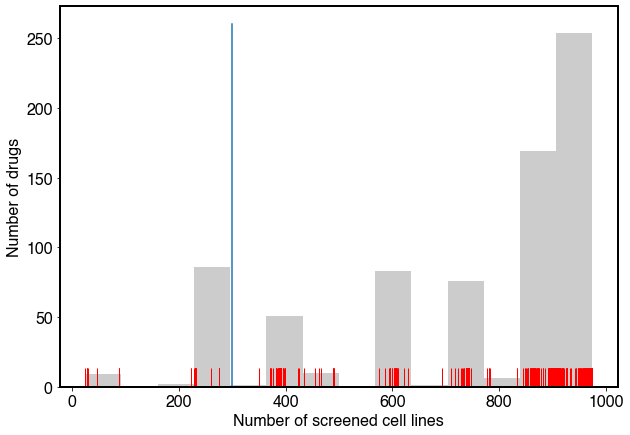

In [34]:
sns.distplot(drug_df.groupby(['drug_id']).size(),
             kde=False,
             hist=True,
             rug=True,
             color='grey',
             rug_kws={'color': 'red'})
plt.plot((300, 300), (0, 260))
plt.xlabel("Number of screened cell lines")
plt.ylabel("Number of drugs")
plt.savefig("../../plots/Fig4S-A.pdf", dpi=500)

In [30]:
print(drug_df['putative_target'].unique().size)

427


In [29]:
drug_df[drug_df['putative_target']!=drug_df['putative_gene_target']]

,num_replicates,RMSE,drug_id,sample_treatment,putative_target,model_treatment,model_name,msi_status,CHEMBL,cell_line_name,model_synonyms,cancer_type_detail,drug_name,putative_gene_target,use_in_publications,model_type,drug_synonyms,RRID,dataset,ln_IC50,model_id,drug_owner,BROAD_ID,master_cell_id,sample_treatment_details,max_screening_conc,cancer_type,target_pathway,tissue,sample_site,growth_properties,webrelease,COSMIC_ID,AUC,PUBCHEM,IC50_raw,IC50_norm_raw,IC50_norm,sensitive,IC50_norm_scaled
386,1.0,0.262734,3,Unknown,MTORC1,NaN,697,MSS,CHEMBL413,697,Line 697;EU-3,B Acute Lymphoblastic Leukemia,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_0079,GDSC1,-5.255411,SIDM01076,MGH,ACH-000070,63,NaN,0.1,B-Lymphoblastic Leukemia,PI3K/MTOR signaling,Haematopoietic and Lymphoid,Bone marrow,Suspension,Y,906800,0.468936,5384616,0.005219,0.052192,-2.952826,1,0.435307
387,1.0,0.202144,3,None,MTORC1,NaN,8-MG-BA,MSS,CHEMBL413,8-MG-BA,NaN,Glioblastoma,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1052,GDSC1,-2.191715,SIDM00998,MGH,ACH-000137,1207,NaN,0.1,Glioblastoma,PI3K/MTOR signaling,Central Nervous System,Frontal Brain lobe,Adherent,Y,687562,0.898868,5384616,0.111725,1.117249,0.110870,0,0.618394
388,1.0,0.045439,3,Unknown,MTORC1,NaN,A253,MSS,CHEMBL413,A253,NaN,Salivary Gland Squamous Cell Carcinoma,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1060,GDSC1,0.302386,SIDM00796,MGH,ACH-000740,2089,NaN,0.1,Head and Neck Carcinoma,PI3K/MTOR signaling,Head and Neck,Submaxillary salivary gland,Adherent,Y,906794,0.985041,5384616,1.353084,13.530836,2.604971,0,0.767441
389,1.0,0.241822,3,Unknown,MTORC1,NaN,A3-KAW,MSS,CHEMBL413,A3-KAW,A3/Kawakami,Diffuse Large B-Cell Lymphoma,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1062,GDSC1,-5.939557,SIDM00495,MGH,ACH-000697,1511,NaN,0.1,B-Cell Non-Hodgkin's Lymphoma,PI3K/MTOR signaling,Haematopoietic and Lymphoid,Ascites,Suspension,Y,910935,0.349757,5384616,0.002633,0.026332,-3.636972,1,0.394422
390,1.0,0.220803,3,Unknown,MTORC1,NaN,A4-Fuk,MSS,CHEMBL413,A4-Fuk,A4/Fukuda,B Acute Lymphoblastic Leukemia,Rapamycin,MTOR,Y,Cell Line,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",CVCL_1064,GDSC1,-4.601047,SIDM00502,MGH,ACH-000157,186,NaN,0.1,B-Lymphoblastic Leukemia,PI3K/MTOR signaling,Haematopoietic and Lymphoid,Ascites,Suspension,Y,910934,0.574998,5384616,0.010041,0.100413,-2.298462,1,0.474412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548524,3.0,0.075639,2638,Unknown,MCL1,NaN,PSN1,MSS,SCHEMBL19472011,PSN1,NaN,Pancreatic Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_1644,GDSC2,2.467330,SIDM00469,GDSC,ACH-000320,560,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Pancreas,Adherent,N,910546,0.842019,NaN,11.790925,1.179093,0.164745,0,0.621613
548525,2.0,0.058714,2638,Unknown,MCL1,NaN,SU8686,MSS,SCHEMBL19472011,SU8686,NaN,Pancreatic Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_3881,GDSC2,5.759466,SIDM01188,GDSC,ACH-000114,268,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Liver,Adherent,N,1240218,0.937823,NaN,317.178984,31.717898,3.456881,0,0.818352
548526,2.0,0.072388,2638,Unknown,MCL1,NaN,SUIT-2,MSS,SCHEMBL19472011,SUIT-2,NaN,Pancreatic Ductal Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_3172,GDSC2,4.074914,SIDM00371,GDSC,ACH-000652,1749,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Liver,Unknown,N,1240219,0.907596,NaN,58.845428,5.884543,1.772329,0,0.717683
548527,2.0,0.077521,2638,Unknown,MCL1,NaN,SW1990,MSS,SCHEMBL19472011,SW1990,NaN,Pancreatic Adenocarcinoma,AZD5991,NaN,Y,Cell Line,NaN,CVCL_1723,GDSC2,3.757604,SIDM01165,GDSC,ACH-000155,1912,NaN,10.0,Pancreatic Carcinoma,Apoptosis regulation,Pancreas,Spleen,Adherent,N,910907,0.867888,NaN,42.845665,4.284566,1.455019,0,0.698720
